<a href="https://colab.research.google.com/github/chaurasiauttkarsh/Sequence-Models/blob/master/Uttkarsh_Chaurasia_Neural_Machine_Translation_by_Jointly_Learning_to_Align_and_Translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please complete the missing parts in the code below. Moreover, please debug the code if the performance is not satisfactory.

# Objective - Neural Machine Translation by Jointly Learning to Align and Translate

In this notebook, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473).


## Preparing Data

We'll be coding up the models in PyTorch and using TorchText to help us do all of the pre-processing required. We'll also be using spaCy to assist in the tokenization of the data.

In [1]:
!pip install torchtext==0.8.1 

     |████████████████████████████████| 7.0MB 13.6MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

First step is to create tokenizers. Eg - "Good Morning!" becomes ["Good", "morning", "!"].

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model. 

**Note**: the models must first be downloaded using the following on the command line: 
```
python -m spacy download en
python -m spacy download de
```

Load the German and English spaCy models.

In [3]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 14.9MB 12.6MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=6a336b5b5148ce98a36beeb9d08bca7588d34dafe6cb3a5853d1bb86a6d47bdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-21u2krns/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [3]:
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

We create the tokenizers.

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Load the data.

Double check that the data loaded has the right number of examples. They should be as follows:

Number of training examples: 29000

Number of validation examples: 1014

Number of testing examples: 1000

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 970kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 273kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 268kB/s]
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [7]:
print("Number of training examples:", len(train_data))
print("Number of validation examples:", len(valid_data))
print("Number of testing examples:", len(test_data))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


Build the vocabulary.

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Define the device.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [26]:
BATCH_SIZE = 128

#Create an iterator below (using BucketIterator) to create your train, validation and test data.
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                      batch_sizes = (BATCH_SIZE, BATCH_SIZE, BATCH_SIZE), 
                                                                      device = device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](assets/seq2seq8.png)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)
                
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](assets/seq2seq9.png)

In [28]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
                
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        attention = self.v(energy).squeeze(2)
                
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](assets/seq2seq10.png)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
                     
        input = input.unsqueeze(0)
            
        embedded = self.dropout(self.embedding(input))
        
        a = self.attention(hidden, encoder_outputs)
        
        a = a.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        weighted = torch.bmm(a, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [31]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [32]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,917 trainable parameters


We create an optimizer.

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

We initialize the loss function.

In [35]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [36]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
                
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [37]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [39]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, train_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 1m 58s
	Train Loss: 5.024 | Train PPL: 152.014
	 Val. Loss: 4.895 |  Val. PPL: 133.585
Epoch: 02 | Time: 1m 58s
	Train Loss: 4.144 | Train PPL:  63.058
	 Val. Loss: 4.354 |  Val. PPL:  77.807
Epoch: 03 | Time: 1m 57s
	Train Loss: 3.460 | Train PPL:  31.822
	 Val. Loss: 3.686 |  Val. PPL:  39.881
Epoch: 04 | Time: 1m 58s
	Train Loss: 2.895 | Train PPL:  18.083
	 Val. Loss: 3.297 |  Val. PPL:  27.026
Epoch: 05 | Time: 1m 58s
	Train Loss: 2.520 | Train PPL:  12.423
	 Val. Loss: 3.006 |  Val. PPL:  20.213
Epoch: 06 | Time: 1m 57s
	Train Loss: 2.216 | Train PPL:   9.170
	 Val. Loss: 2.728 |  Val. PPL:  15.310
Epoch: 07 | Time: 1m 58s
	Train Loss: 1.952 | Train PPL:   7.043
	 Val. Loss: 2.561 |  Val. PPL:  12.951
Epoch: 08 | Time: 1m 57s
	Train Loss: 1.748 | Train PPL:   5.746
	 Val. Loss: 2.412 |  Val. PPL:  11.154
Epoch: 09 | Time: 1m 58s
	Train Loss: 1.604 | Train PPL:   4.974
	 Val. Loss: 2.273 |  Val. PPL:   9.712
Epoch: 10 | Time: 1m 58s
	Train Loss: 1.466 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

### The model should achieve a perplexity of 30 or lower on the test data.

In [40]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


| Test Loss: 3.361 | Test PPL:  28.824 |


### Please suggest any other ways/techniques/models that could improve the performance on this task.

The following methods can be used to improve the performance of neural machine translation noticeably.

# **Improving the Current Model**

## 1. Pretraining

By training deep neural networks with a small amount of training data, the risk of producing a model that performs poorly is increased. One technique for mitigating this disadvantage is pretraining the model, which involves initialising (part of) the model's parameters using parameters from another model. 

Pretraining has resulted in promising results when used in conjunction with SEQ2SEQ models for NLP tasks.

These are discussed in the following papers.

https://www.cs.toronto.edu/~hinton/absps/ncfast.pdf

https://dl.acm.org/doi/10.5555/2976456.2976476

## 2. Batch Size
Recent NMT research has used values such as 64 or 128. Discussed in the following papers.

https://www.aclweb.org/anthology/D15-1044/

https://arxiv.org/abs/1609.08144

The following paper examined the effect of batch size on NMT and discovered that, for batch sizes of 8 to 64, a larger batch size has a positive effect on model performance.

https://www.aclweb.org/anthology/W17-3208/



## 3. Preprocessing : SentencePiece

It is a corpus-based unsupervised text tokenizer and detokenizer. SentencePiece determines token boundaries based on statistical models such as character n-grams using raw sentences (a white space is treated as a character). This, like using subword units, resolves the issue of unknown tokens. We can use unigram for this model because it is the default setting in the given implementation.

https://github.com/google/sentencepiece

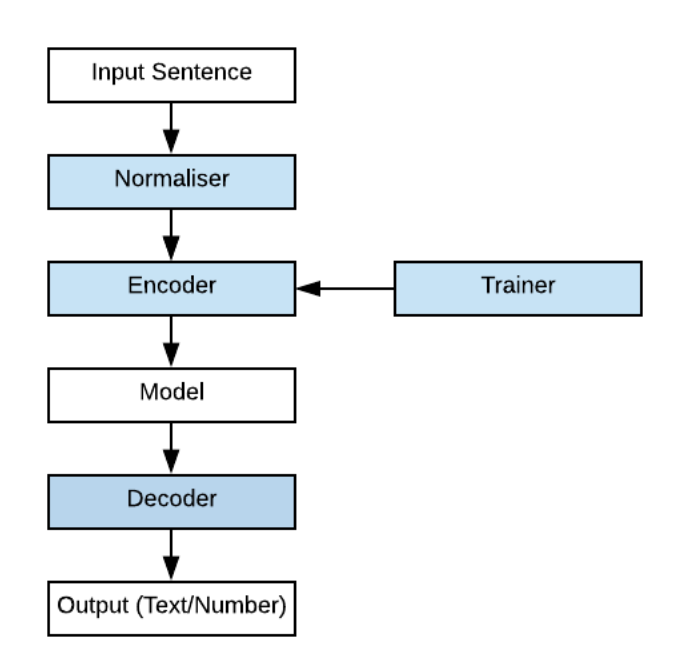



## 4. Beam Search

A beam search is frequently used to preserve tractability in large systems that lack the memory required to store the entire search tree. To determine the best translation, each section is processed, and a variety of possible translations for the words appear. The top-scoring translations are retained, while the remainder are discarded. The translator then evaluates the translations against a predefined criterion, selecting the translation that most closely adheres to the objectives.

https://arxiv.org/abs/1606.02960

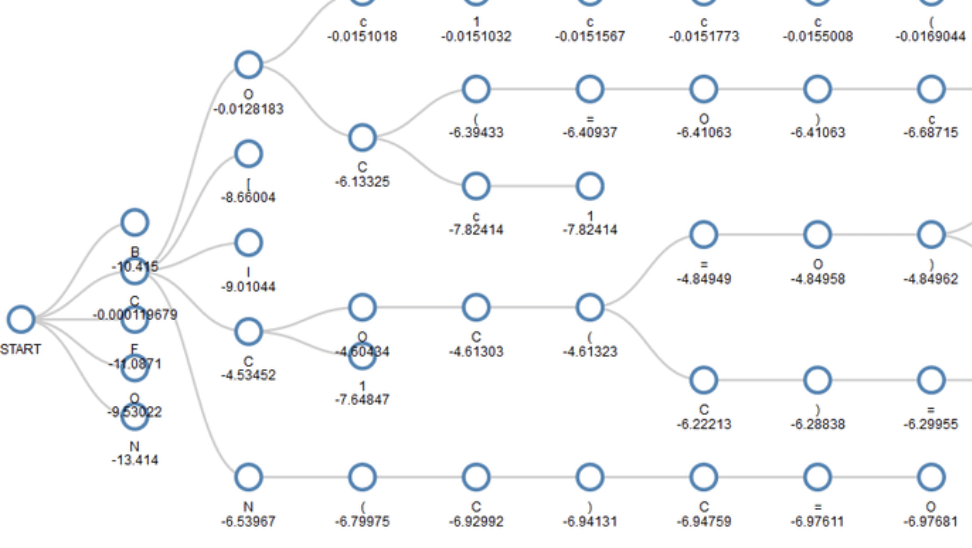

## 5. Larger Batch Size

The accuracy of a gradient at each step depends on batch size, the number of samples in a minibatch. A larger batch size leads to a more accurate gradient.

https://arxiv.org/pdf/1901.08256.pdf

# **Transformer : Model**




Transformer is a model that was introduced in 2017 in the article "Attention is All You Need." It is entirely based on attention mechanisms, i.e., it is devoid of recurrence and convolutions. Along with improved translation quality, the model is up to an order of magnitude faster to train.

Transformer pioneered a new modelling paradigm: in contrast to previous models, which used recurrence or convolutions to perform processing within the encoder and decoder, Transformer utilises only attention.

https://arxiv.org/abs/1706.03762

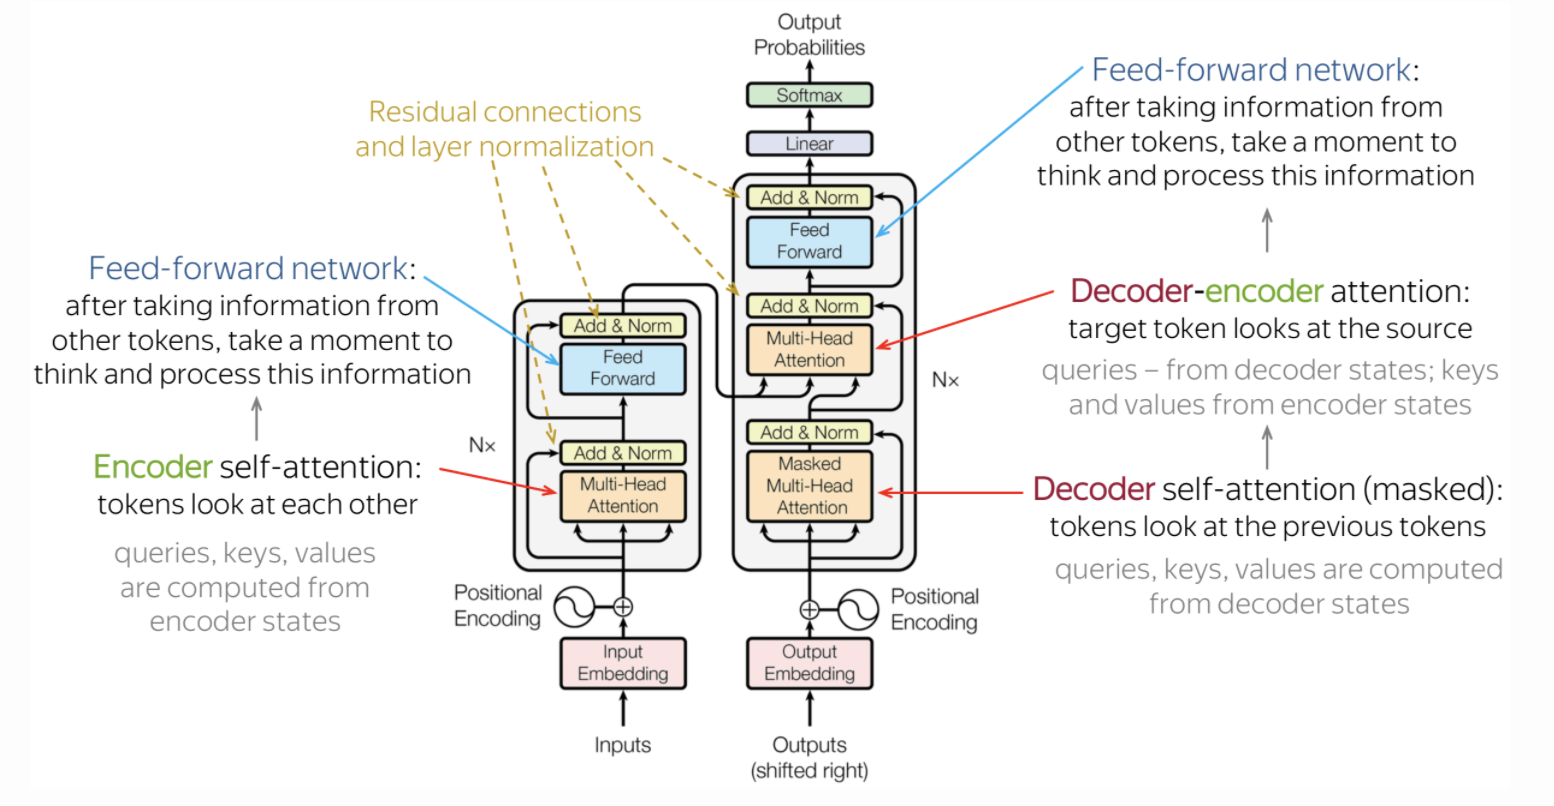

The components of model:

## 1. Feed-forward blocks

Along with attention, each layer contains a feed-forward network block: two linear layers connected by a ReLU non-linearity.

**FFN(x) = max(0, xW1 + b1)W2 + b2**

After inspecting other tokens via an attention mechanism, a model processes this new information using an FFN block.

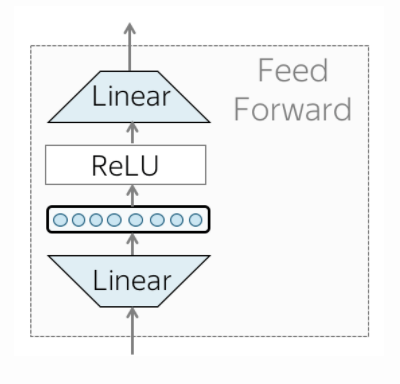



## 2. Residual Connections

Residual connections connect the input of a block to its output. They facilitate gradient flow within a network and enable the stacking of numerous layers.

After each attention and FFN block in the Transformer, residual connections are used.

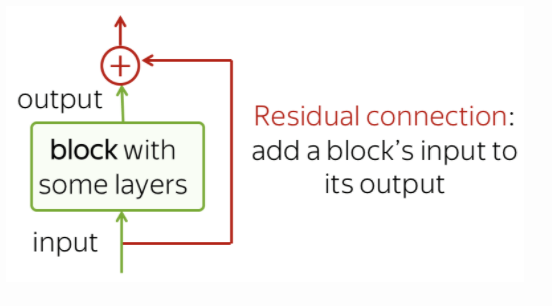


## 3. Layer Normalization

The term "Norm" refers to Layer Normalization in the "Add & Norm" layer. It normalises the vector representation of each example in batch independently - this is done to maintain control over "flow" to the next layer. Normalization of the layers improves convergence stability and, in some cases, quality.

It also has trainable parameters scale and bias.

```
# This is formatted as code
```



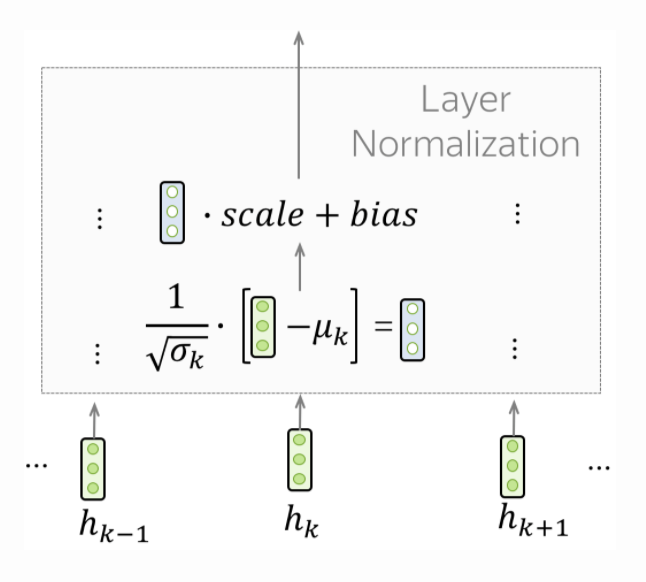

## 4. Positional Encoding

Notably, because Transformer lacks recursion and convolution, it is unaware of the order of the input tokens. As a result, we must explicitly inform the model of the token positions. We have two sets of embeddings for this: one for tokens  and another for positions. Then the input representation of a token is the sum of its token and positional embeddings.

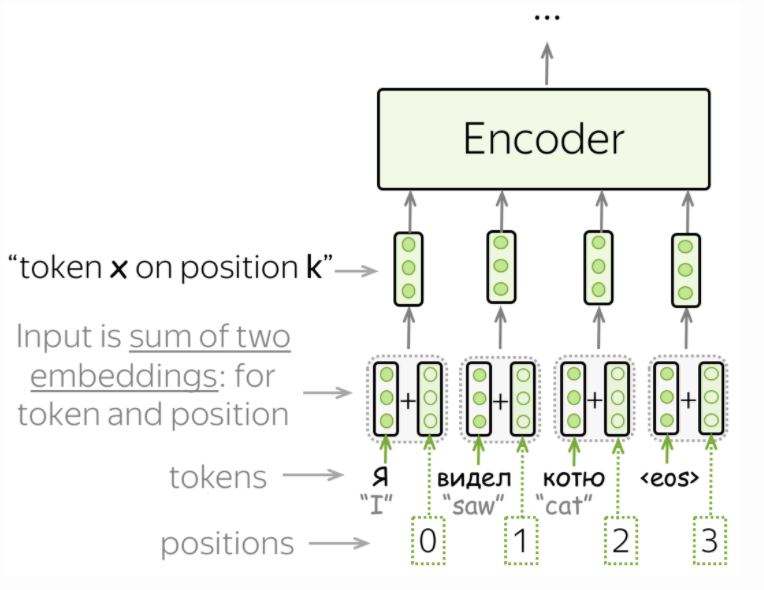

# **Byte Pair Encoding : Segmentation**




Here we represent all words, even those we haven't seen in the training data. It familiarises the model with the parts a word consists of - subwords, by splitting the rare and unknown words into smaller parts.

This is precisely what Rico Sennrich, Barry Haddow, and Alexandra Birch proposed in their paper Neural Machine Translation of Rare Words with Subword Units. They established Byte Pair Encoding as the de facto standard for subword segmentation (BPE). BPE retains common words and divides uncommon and unknown ones into smaller known parts.

https://arxiv.org/pdf/1508.07909.pdf


BPE algorithm consists of two parts:

**Training** - learn "BPE rules", i.e., which pairs of symbols to merge.

**Inference** - apply learned rules to segment a text.



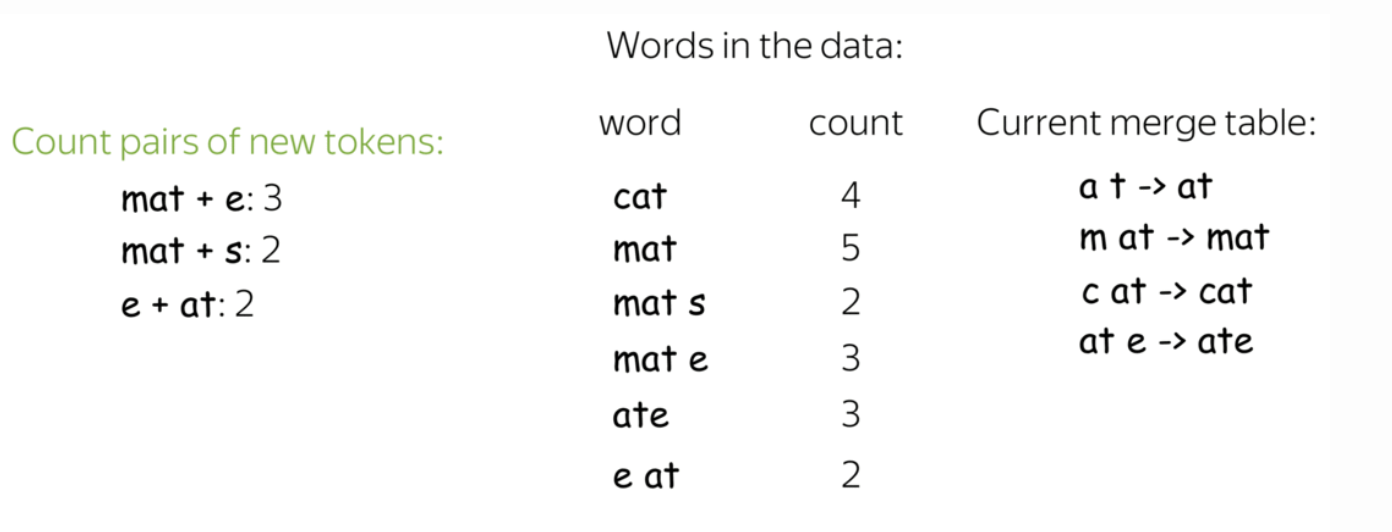

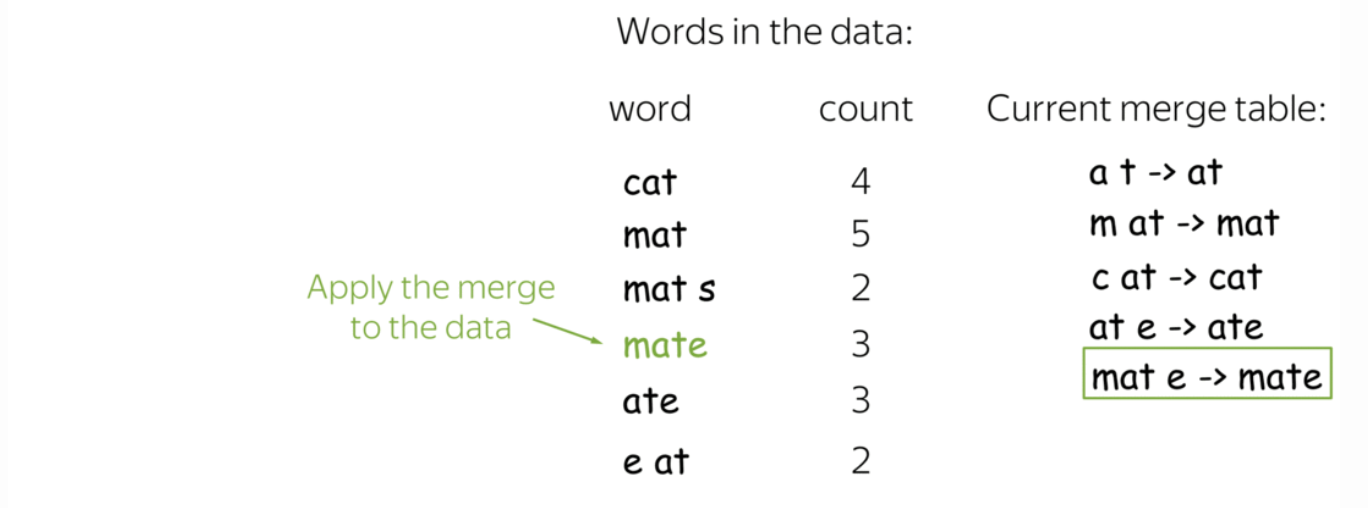

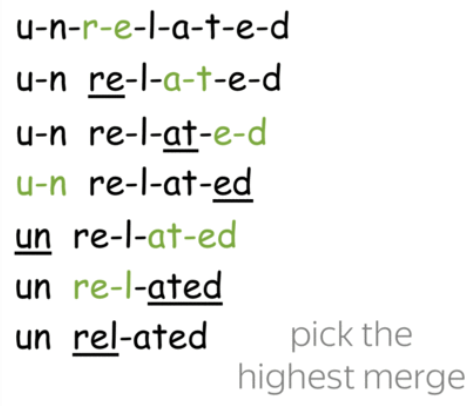

# **Gradient Clipping**

Gradient clipping is believed to alleviate the issue of vanishing/exploding gradients in recurrent neural networks.

We establish thresholds to maintain the gradient within a specified boundary. For instance, the threshold's range is between -1 and 1.

https://openreview.net/pdf?id=BJgnXpVYwS

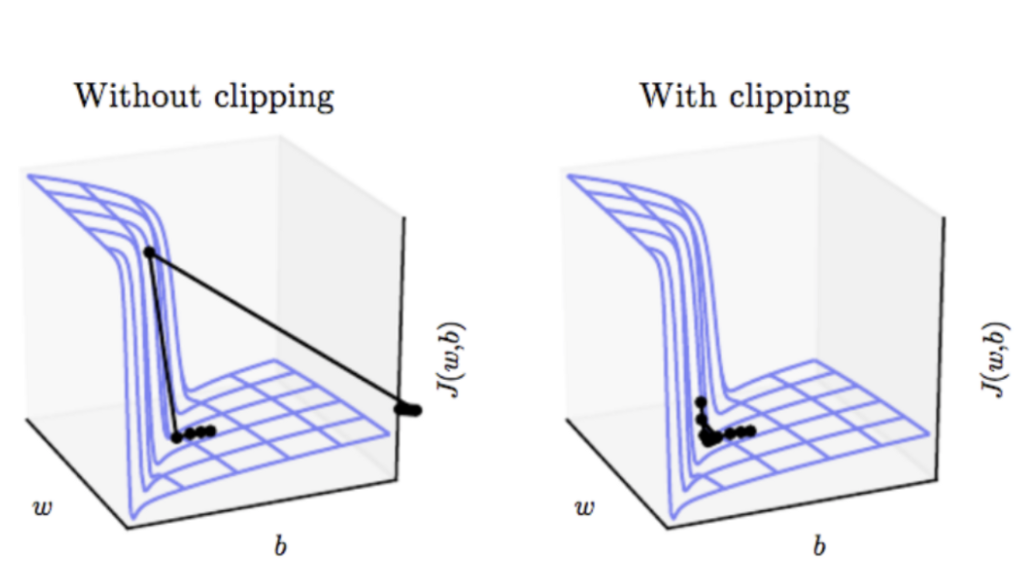